===================================================
## 2. POD-MLP-deriv
#### a multi-layer perceptron (f) trained to predict the next increment $\alpha_{n+1} = \Delta t f(\alpha_n) + \alpha_n$
#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

'2.POD-MLP-deriv.ipynb'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

## Load data

In [11]:
pod_coeffs = np.loadtxt('POD_coeffs.csv', delimiter=',') 

X_pod = np.transpose(pod_coeffs)
step = 1
times = np.arange(0, len(X_pod), step, dtype="float64")

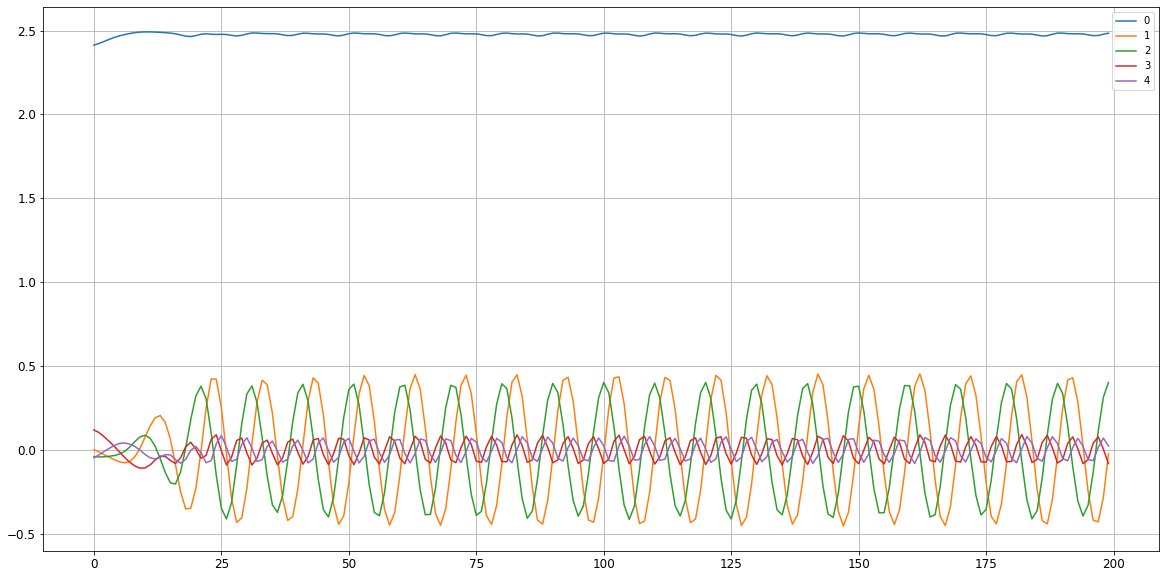

In [6]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times[:200], X_pod[:200]);
ax.grid()
ax.legend(range(5))

## Prepare data

In [77]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Reconstruct the time series into a supervised learning dataset.
    input:
    data, list or array, sequence of observations
    n_in, int, length of lagging observations (X)
    n_out, int, length of observations (y)
    dropnan, boolean, discard rows with NaN values
    return:
    Pandas DataFrame, reconstructed dataset
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input series (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # predict series (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concat column name with data
    agg = concat(cols, axis=1)
    agg.columns = names
    # discard rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [296]:
def set_deriv(df):
    """
    Calculate the time derivative by (a_n+1 - a_n)/step
    """
    for i in range(1, 6):
        df["var%d(deriv)"%i] = (df["var%d(t)"%i] - df["var%d(t-1)"%i]) / step
        df=df.drop(columns=["var%d(t)"%i])
    return df

In [297]:
# create dataset
dataset = DataFrame()
for i in range(5):
    dataset['ob%d'%i] = X_pod[:,i]
values = dataset.values
# make sure all values are float
values = values.astype('float32')
# Structured as a supervised learning problem
reframed = series_to_supervised(values, 1, 1)
# Calulate the derivative
deriv = set_deriv(reframed)
# Normalized
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(deriv.values)
values = scaled

In [298]:
deriv.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(deriv),var2(deriv),var3(deriv),var4(deriv),var5(deriv)
1,2.412792,0.001982,-0.039025,0.119799,-0.046316,0.010206,-0.013468,-0.002241,-0.015665,0.017710
2,2.422999,-0.011486,-0.041265,0.104135,-0.028606,0.011758,-0.015905,0.001225,-0.025024,0.020054
3,2.434756,-0.027391,-0.040040,0.079111,-0.008552,0.012629,-0.015367,0.002930,-0.027801,0.018724
4,2.447385,-0.042758,-0.037110,0.051310,0.010172,0.011466,-0.014616,0.004474,-0.029614,0.017370
5,2.458851,-0.057374,-0.032636,0.021696,0.027542,0.009357,-0.012453,0.008380,-0.032535,0.011899


In [190]:
# split train and test set by 9:1
n_train = 898
train = values[:n_train, :]
test = values[n_train:, :]
# create input and output
X_train, y_train = train[:, :5], train[:, 5:]
X_test, y_test = test[:, :5], test[:, 5:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(898, 5) (898, 5) (100, 5) (100, 5)


## Train with MLP

In [94]:
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [95]:
epochs = 40
batch_size = 256
lr = 0.001
optimizer = optimizers.Adam(lr=lr, decay=0.0)

In [96]:
n_input = X_train.shape[1]
n_output = y_train.shape[1]

In [97]:
# design MLP
model = Sequential()
#model.add(Flatten(input_shape=X_train.shape))
model.add(Dense(100, activation="relu", input_dim=n_input))
model.add(Dense(n_output))
model.summary()
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


In [98]:
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, shuffle=False)

In [318]:
history.history

{'loss': [0.24707556172442063,
  0.19850454919189547,
  0.15961180597477342,
  0.13002873522401653,
  0.10891852176069948,
  0.09494440758679651,
  0.08619725025509939,
  0.08033865579053394,
  0.07537884542299539,
  0.07028583946631586,
  0.06487614734467526,
  0.05949043192151925,
  0.054450528111250736,
  0.04986401704577667,
  0.04567768506058606,
  0.041766300349432,
  0.038077919588389006,
  0.03460623395270388,
  0.031371515779393025,
  0.028369100328808638,
  0.0255899510008256,
  0.023016283703441078,
  0.020631159525074248,
  0.018459313343754058,
  0.01654155832613696,
  0.01480909616360752,
  0.013239896348065681,
  0.011824310265630815,
  0.010550260771986902,
  0.009408228966368068,
  0.00838680648222101,
  0.007474358267210972,
  0.006654353445200851,
  0.0059177400305751035,
  0.005258366954046196,
  0.004672874911752569,
  0.004158672531817797,
  0.0037110857006975497,
  0.003324532993386742,
  0.002995659027327441],
 'accuracy': [0.29175946,
  0.24721603,
  0.19265033

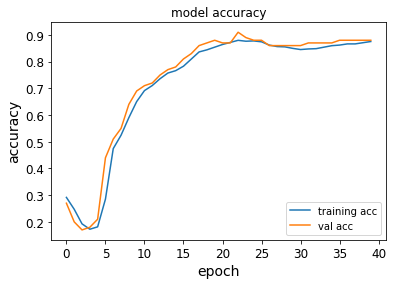

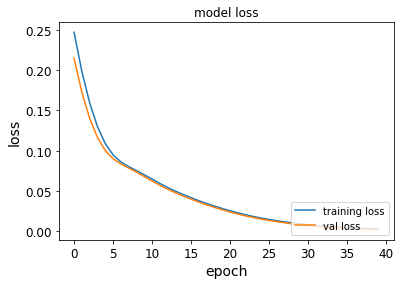

In [99]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['accuracy'],label='training acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

fig = plt.figure()
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')

Predict on test set

In [310]:
# make prediction
yhat = model.predict(X_test)
# Inverse scaling predicted value
yhat_inv = np.concatenate((X_test, yhat), axis=1)
yhat_inv = scaler.inverse_transform(yhat_inv)
yhat_inv = yhat_inv[:, 5:]
# Inverse scaling true value
y_inv = scaler.inverse_transform(test)
y_inv = y_inv[:, 5:]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_inv, yhat_inv))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.012


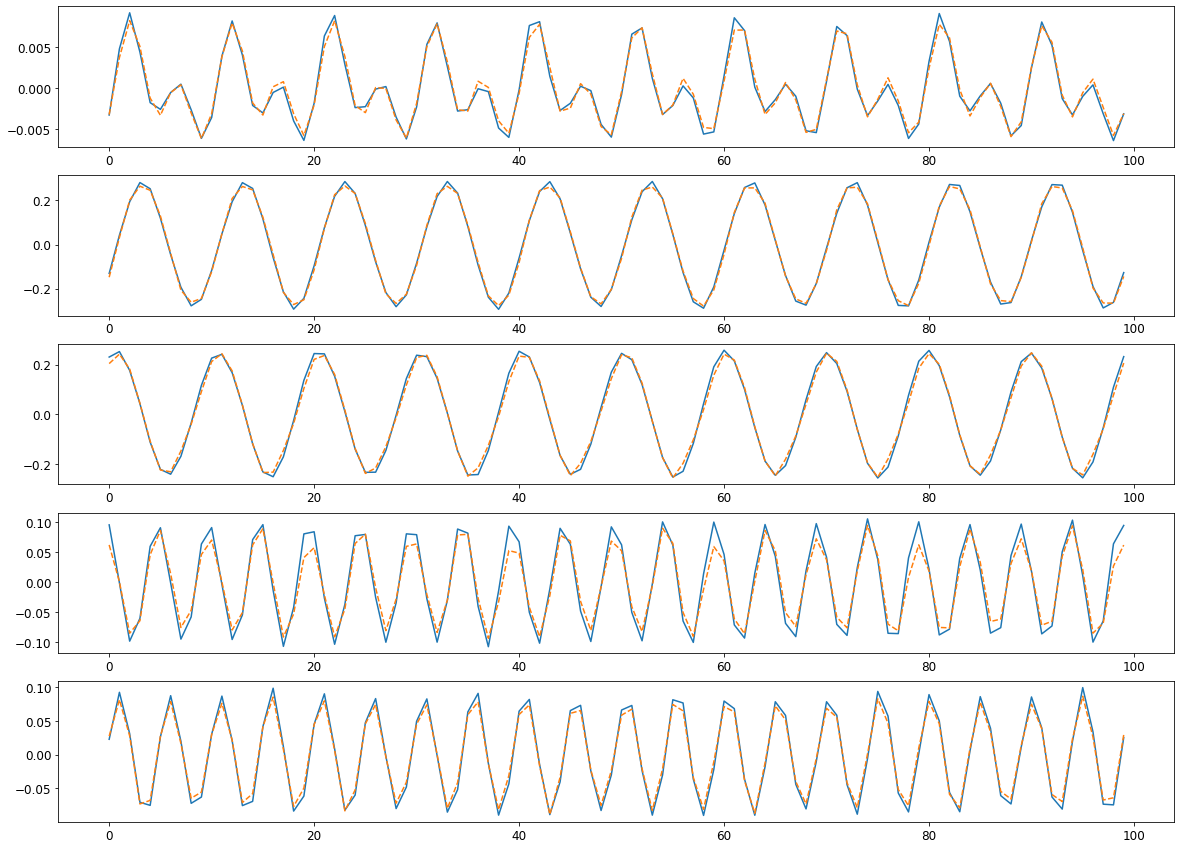

In [311]:
fig, ax = plt.subplots(5, 1, figsize=[20,15])
for i in range(5):
    ax.flatten()[i].plot(y_inv[:,i])
    ax.flatten()[i].plot(yhat_inv[:,i],'--')

In [312]:
# Calculate the predicted value of the next time step
# a_n+1 = step*f(a_n) + a_n
y_pred = step * yhat_inv + deriv.values[898:, :5]

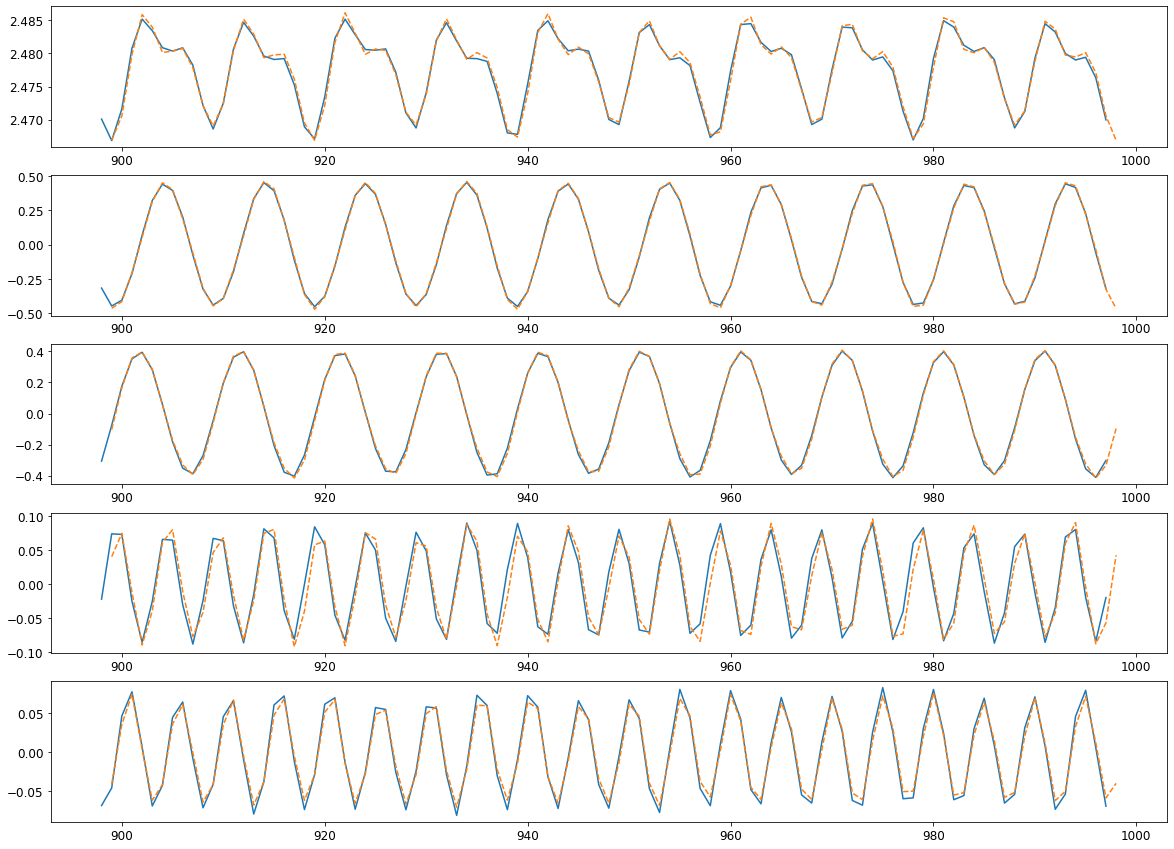

In [314]:
fig, ax = plt.subplots(5, 1, figsize=[20,15])
for i in range(5):
    ax.flatten()[i].plot(times[898:-1], deriv.values[898:, i])
    ax.flatten()[i].plot(times[899:], y_pred[:,i],'--')

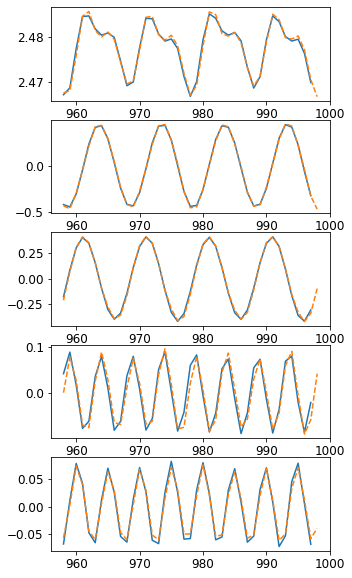

In [317]:
fig, ax = plt.subplots(5, 1, figsize=[5,10])
for i in range(5):
    ax.flatten()[i].plot(times[958:-1], deriv.values[958:, i])
    ax.flatten()[i].plot(times[958:], y_pred[59:,i],'--')

In [303]:
def predict_next_time_level(x_test, x_inv, time_level):
    for i in range(time_level+1):
        yhat = model.predict(x_test)
        yhat_inv = np.concatenate((x_test, yhat), axis=1)
        yhat_inv = scaler.inverse_transform(yhat_inv)
        yhat_inv = yhat_inv[:, 5:]
        y_pred = step * yhat_inv + x_inv

        y_next = np.concatenate((y_pred, x_inv), axis=1)
        y_next = scaler.transform(y_next)
        y_next = y_next[:, :5]
        x_test = np.concatenate((x_test, [y_next[-1]]), axis=0)
        x_inv = np.concatenate((x_inv, [y_pred[-1]]), axis=0)
        
    return y_pred

In [304]:
time_level_pred = predict_next_time_level(X_test, deriv.values[898:, :5], 100)
times_pred = np.arange(0, len(X_pod)+100, step, dtype="float64")

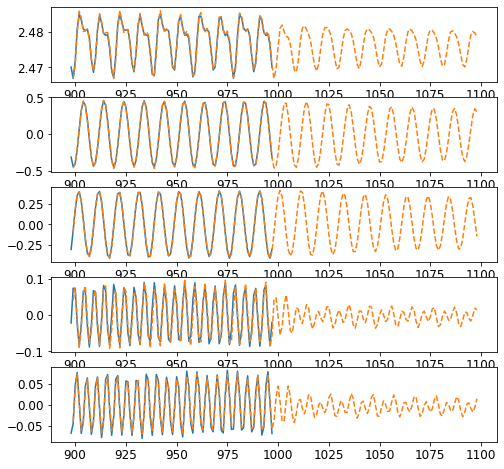

In [308]:
fig, ax = plt.subplots(5, 1, figsize=[8,8])
for i in range(5):
    ax.flatten()[i].plot(times[898:-1], deriv.values[898:, i])
    ax.flatten()[i].plot(times_pred[899:], time_level_pred[:,i],'--')

Output as `csv`

In [307]:
pod_coeffs_2 = np.transpose(time_level_pred)
np.savetxt('POD_coeffs_2.csv', pod_coeffs_2 , delimiter=',')

Predict on full set

In [290]:
# make prediction
X_fullset = values[:, :5]
yhat = model.predict(X_fullset)
# Inverse scaling predicted value
yhat_inv = np.concatenate((X_fullset, yhat), axis=1)
yhat_inv = scaler.inverse_transform(yhat_inv)
yhat_inv = yhat_inv[:, 5:]
# Inverse scaling true value
y_inv = scaler.inverse_transform(values)
y_inv = y_inv[:, 5:]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_inv, yhat_inv))
print('Fullset RMSE: %.3f' % rmse)

Fullset RMSE: 0.014


In [292]:
# Calculate the predicted value of the next time step
y_pred = step * yhat_inv + deriv.values[:, :5]

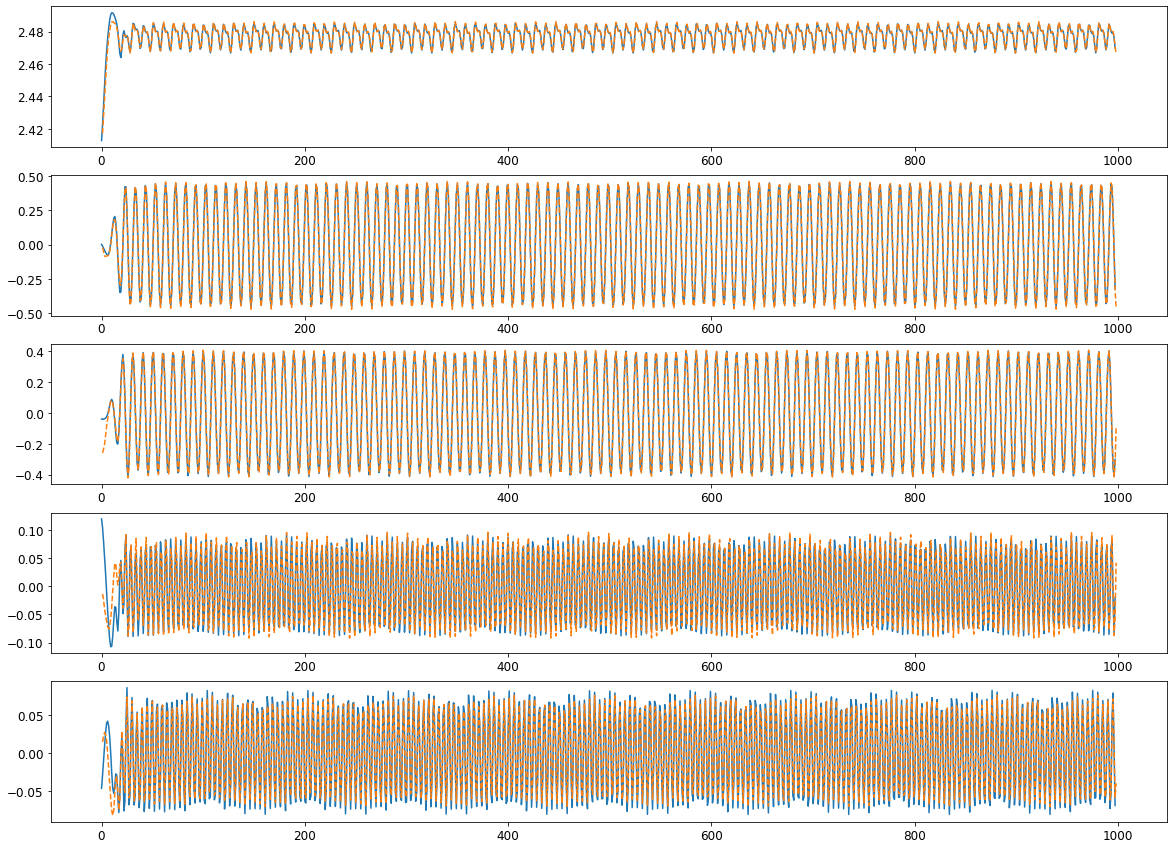

In [293]:
fig, ax = plt.subplots(5, 1, figsize=[20,15])
for i in range(5):
    ax.flatten()[i].plot(times[:-1], deriv.values[:,i])
    ax.flatten()[i].plot(times[1:], y_pred[:,i],'--')